In [ ]:
from tokenize import PlainToken
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
import time
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

from NeuralNets import Network
import os
# Set multiprocessing start method
mp.set_start_method('spawn', force=True)

# Set default tensor type
d_type = torch.float32
torch.set_default_dtype(d_type)
import warnings
warnings.filterwarnings("ignore")


/opt/anaconda3/envs/deeprl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## High Dimensional Test

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
from Path_MKV_Solver_2 import PathMKV
from Parameters import DefaultParams

In [4]:
import torch.nn.functional as F

class HighDimPathModel():
    def __init__(self, params, kappa=0.6, sigma=0.1, eta=0.01, K=1.25, T=1,  c=1, \
        mu_0 = 0, sigma_0 = 0.5) -> None:
        params_equ = params["equation"]
        params_train = params["train"]

        self.d = params_equ["state_dim"] # dimension of Xt
        # dim of Brownian motion
        self.BM_dim = params_equ["BM_dim"]
        # dim of control 
        self.u_dim = params_equ["u_dim"]
        # number of samples
        self.M = params_equ["M"]
        self.N = params_equ["N"]
        self.device = params_train["device"]

        self.terminal = params_equ["T"]
        sigma = 1/(self.d * self.u_dim) * np.ones([self.d, self.u_dim]) + np.random.rand(self.d, self.u_dim) * sigma
        self.sigma_ = sigma 

        self.kappa = kappa
        self.K = K
        self.c = c
        self.eta = eta
        self.delay = 4




        # default mean and covariance for the initial random variable
        self.mu0 = mu_0 * torch.tensor(np.ones(self.d)).float().to(self.device)
        self.var0 = sigma_0**2 * torch.tensor(np.eye(self.d)).float().to(self.device) 
    
    def change_mean_var(self, mu0, var0):
        """
        mu0: numpy array [d,]
        sigma0: numpy matrix [d * d]
        """
        self.mu0 = torch.tensor(mu0).float().to(self.device)
        self.var0 = torch.tensor(var0).float().to(self.device)


    
    def generate_initial_condition(self):
        # Shape: (M, d)
        L = torch.linalg.cholesky(self.var0)
        Gaussian_noise = torch.randn(self.M, self.d, device=self.device).float()
        x = self.mu0 + Gaussian_noise @ L.T 
        return x #x.view(self.d*self.M)

    
    def mu(self, j, dt, t, X_path, control):
        """
        X:  (M, j+1, d)
        control: (M, d)

        return: (M,d)
        """
        Xt = X_path[:, -1]
        if self.delay > 0:
            if j <= self.delay: return 0 * Xt # just to match the dimension
            Xt_minus_2 = X_path[:, -3]
            return  (Xt - Xt_minus_2 +  control) * dt
        else:
            return  (Xt  +  control) * dt

    def sigma(self, DW_t, t, X_path, control):
        # if t[0,0] <= self.delay: return 0
        sigma_torch = torch.from_numpy(self.sigma_).to(DW_t.device, dtype=DW_t.dtype)
        
        mat1 = sigma_torch.unsqueeze(0).expand(self.M, self.d, self.BM_dim)  # (500, 100, 2)
        # print("mat1", np.shape(mat1))
        mat2 = DW_t.unsqueeze(2)                      # (500, 2, 1)
        # print("mat2", np.shape(mat2))
        result = torch.bmm(mat1, mat2).squeeze(-1)                # (500, 100, 2)


        return result
        
    
    def get_mean_expanded(self, Xt):
        """
        Xt: Batch size (M) * d  

        return: M copies of mu_t in shape of (M,d)
        """
        return torch.mean(Xt, axis=0).expand(self.M,-1) # (M,d)

    def get_empirical_prob(self, Xt):
        return  torch.mean(1.0*(Xt >= 0.05), axis=0).expand(self.M, -1)

    def f_running(self, j, t, X_path, control):
        """
        j: an integer in [0, 1, ..., N-1]
        t: tensor(constant)
        """
        # print("time,", t[0])
        if t[0,0] <= self.delay:
            return 0
        return self.eta * torch.mean(torch.bmm(control.unsqueeze(1), control.unsqueeze(2))) 
 
    def g_terminal(self, XT):
        #X_path: (M, T+1, d)
        AT = torch.mean(XT, dim=1)
        var_payoff = torch.var(AT - self.K)
        return self.c * var_payoff

    def get_control(self, j, t_, X_path, dw, control_type):
        """
        j: an integer in [0, 1, ..., N-1]
        t: (M, 1)
        X_path: (M, j+1, d)
        """
        X0 = X_path[:,0,:]
        Xt = X_path[:,j,:]  
    

  
        hist_len = self.N + 1
        pad_len = hist_len - X_path.size(1)
        X_path_padded = F.pad(X_path, (0, 0, 0, pad_len), mode='constant', value=0.0) # [N+1, d]
        # 
        ## Generate the control based on control type
        if control_type == "B":     
            net_input = torch.cat([t_,  X0, dw], dim=1)
            
        elif control_type == "X": 
            net_input = torch.cat([t_,  X_path_padded.view(self.M,-1)], dim=1)       # (M, hist_len, d)
            net_input = net_input.view(self.M,-1)
            

        elif control_type == "Xt":

            net_input = torch.cat([t_, Xt], dim=1)
            net_input = net_input.view(self.M,-1)
                
        return net_input



In [5]:
from Param import DefaultParams

In [ ]:
params = DefaultParams(d=2,control_type='X').params

{'B': 103, 'X': 103, 'Xt': 3}


In [ ]:
setup = HighDimPathModel(params) 

In [8]:
solver_B = PathMKV(setup, params)
t, W, DW = solver_B.fetch_minibatch()
X0 = solver_B.setup.generate_initial_condition()

⚠️ Pre-trained model not found at outputNN/.pth. Starting from scratch.


current filename: path_X_d_2


In [9]:
net_control_B = Network(params["net"]) 


In [10]:
_ = solver_B.loss_function(net_control_B, t, DW, X0)

In [11]:
solver_B.train()

100%|██████████| 50/50 [00:20<00:00,  2.40it/s]


It: 0, loss_training: 0.0524, loss_validation: 0.0516
Updated learning rate: 0.001


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


It: 1, loss_training: 0.0331, loss_validation: 0.0321
Updated learning rate: 0.001


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


It: 2, loss_training: 0.0281, loss_validation: 0.0318
Updated learning rate: 0.001


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


It: 3, loss_training: 0.0238, loss_validation: 0.0253
Updated learning rate: 0.001


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]

It: 4, loss_training: 0.0237, loss_validation: 0.0235
Updated learning rate: 0.001


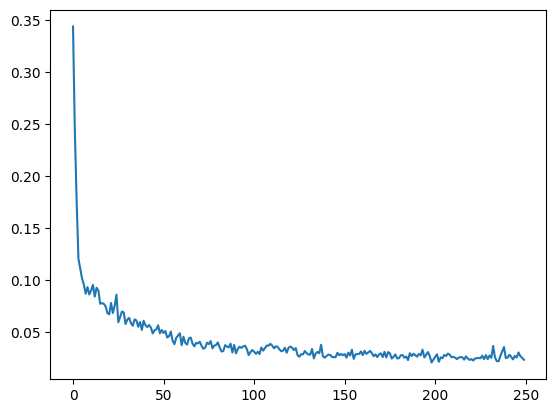

In [12]:
plt.plot(solver_B.training_cost_list)

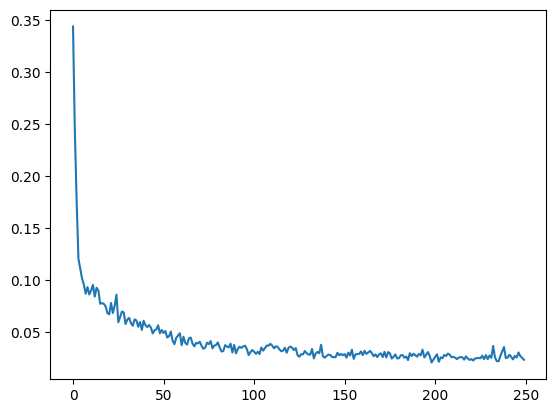

In [13]:
plt.plot(solver_B.training_cost_list)

In [14]:
setup_B = DelayPathModel(paramsB)
solver_B = PathMKV(setup_B, paramsB)
t, W, DW = solver_B.fetch_minibatch()
#X_path = torch.stack(X_buffer, dim=1) 
X0 = solver_B.setup.generate_initial_condition()


NameError: name 'DelayPathModel' is not defined

In [ ]:
X_buffer, reward = solver_B.loss_function(net_control_B, t, DW, X0)

In [ ]:
reward

In [ ]:
setup_B.mu()

In [ ]:
# setup_A = MVPathModel(paramsA)
# setup_X = MVPathModel(paramsX)
# setup_D = MVPathModel(paramsD)
setup_M = MVPathModel(paramsM)

In [ ]:
# solver_M = PathMKV(setup_M, paramsM)
# solver_M.train_players()


In [ ]:
# solver_M.save_NN()
# solver_M.save_loss()


In [ ]:
# solver_M.train_players()
# solver_M.save_NN()
# solver_M.save_loss()


In [ ]:
solver_B = PathMKV(setup_B, paramsB)
# solver_B.train_players()
# solver_B.save_NN()
# solver_B.save_loss()

In [ ]:
net_control_B = Network(paramsB["net"]) 
# Load all models from file
old_filename = 'path_B_d_1'
loaded = torch.load("outputNN/" + old_filename + ".pth")
net_control_B.load_state_dict(loaded['net_actor'])

setup_B = MVPathModel(paramsB)
solver_B = PathMKV(setup_B, paramsB, saved_NN_file=old_filename)

In [ ]:
net_control_M = Network(paramsM["net"]) 
# Load all models from file
old_filename = 'path_Xt_d_1'
loaded = torch.load("outputNN/" + old_filename + ".pth")
net_control_M.load_state_dict(loaded['net_actor'])

setup_M = MVPathModel(paramsM)
solver_M = PathMKV(setup_M, paramsM, saved_NN_file=old_filename)

In [ ]:

# # Example data
# solver_B.M = 500
# setup_B.M = 500

# solver_M.M = 500
# setup_M.M = 500

X_buffer1, _, _ =solver_M.simulation_paths()
X_path1 = torch.stack(X_buffer1, dim=1)  # [X0, X1, ..., XT]

X_buffer2, _, _ =solver_B.simulation_paths()
X_path2 = torch.stack(X_buffer2, dim=1)  # [X0, X1, ..., XT]

X1 = X_path1.detach().squeeze(-1).numpy()          # α₁
X2 = X_path2.detach().squeeze(-1).numpy()    # α₂

In [ ]:
np.shape(X1[:,-1]), np.shape(X2[:,-1])

In [ ]:
plt.hist(X1[:,-1], bins=50, alpha=0.5, density=False)
plt.hist(X2[:,-1], bins=50, alpha=0.5, density = False)
plt.xlim([-1., 3.5])
plt.show()

In [ ]:
# solver_B.train_players()
# solver_B.save_NN()
# solver_B.save_loss()

In [ ]:
# # plt.plot(solver_D.training_cost_list)
# df1 = pd.read_csv("outputLoss/path_Ad_1_d_1_val_loss.csv")
# plt.plot(df1, alpha=0.5, label=r"$a(t, A)$")
# # plt.plot(solver_D.training_cost_list[:5000], alpha=0.5, label=r"$a(t, X_t, A_t)$")
# # plt.plot(solver_B.training_cost_list)

df2 = pd.read_csv("outputLoss/path_Xt_d_1_val_loss.csv")
plt.plot(list(df2.values[:,0]), alpha=0.5, label=r"$a(t, X)$")

# plt.plot(solver_M.training_cost_list, alpha=0.5, label=r"a(t, X_t)")

df = pd.read_csv("outputLoss/path_B_d_1_val_loss.csv")
plt.plot(list(df.values[:,0]), alpha=0.5, label=r"$a(t, \Delta W)$")



plt.legend()
plt.xlabel("Epoch t")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# solver_B = PathMKV(setup_B, paramsB)
# solver_B.train_players()
# solver_B.train_players()

In [ ]:
# solver_A = PathMKV(setup_A, paramsA)
# solver_A.train_players()
# solver_A.train_players()
# solver_A.save_NN()
# solver_A.save_loss()

In [ ]:
# plt.plot(np.array(solver_A.training_cost_list) - np.array(solver_B.training_cost_list))
# plt.plot(solver_B.validation_list)
# plt.plot(solver_B.training_cost_list, alpha=0.5)

In [ ]:
solver_X = PathMKV(setup_X, paramsX)
solver_X.train_players()
solver_X.train_players()
solver_X.save_NN()
solver_X.save_loss()

In [ ]:
solver_B = PathMKV(setup_B, paramsB)
solver_B.train_players()


In [ ]:
solver_B.train_players()
solver_B.save_NN()
solver_B.save_loss()

In [ ]:
np.var(solver_A.training_cost_list[-500:]), np.var(solver_B.training_cost_list[-500:]), np.var(solver_X.training_cost_list[-500:])


# Example: training_loss is a list or array of length 5000
# training_loss = [...]

window_size = 200
n_windows = len(solver_A.training_cost_list) // window_size

# Compute variance per window
variances1 = [
    np.var(solver_A.training_cost_list[i*window_size:(i+1)*window_size])
    for i in range(n_windows)
]
variances2 = [
    np.var(solver_B.training_cost_list[i*window_size:(i+1)*window_size])
    for i in range(n_windows)
]
variances3 = [
    np.var(solver_X.training_cost_list[i*window_size:(i+1)*window_size])
    for i in range(n_windows)
]

# Plot
plt.figure(figsize=(8,4))
plt.plot(range(n_windows), variances1, marker='o')
plt.plot(range(n_windows), variances2, marker='o')
plt.plot(range(n_windows), variances3, marker='o')

plt.xlabel('Window index (each of 500 steps)')
plt.ylabel('Variance of loss')
plt.title('Variance of training loss per 500-step window')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(solver_A.training_cost_list,alpha=0.5)
# plt.plot(solver_X.training_cost_list[-2500:],alpha=0.5)
plt.plot(solver_B.training_cost_list,alpha=0.5)



In [ ]:
X_buffer2, _, _ =solver_B.simulation_paths()
X_path2 = torch.stack(X_buffer2, dim=1)  # [X0, X1, ..., XT]


X2 = X_path2.detach().squeeze(-1).numpy()    # α₂


In [ ]:
np.shape( X_path2[:,-1])


In [ ]:
np.shape(X2)

In [ ]:


plt.style.use('default')
K = 1.25
X1 = X2[:,:,0]
X2 = X2[:,:,0]
AT_1 = np.abs(np.mean((X1), axis=1) - K)
X1_avg = np.mean((X1), axis=1)
# plt.figure(figsize=(7,4.5))
mean1 = np.mean(AT_1)
var1 = np.var(AT_1)
print(mean1, var1)
plt.hist(X1_avg, density=True, bins=150, alpha=0.5,   \
    label=r"$\alpha(t, A)$" + " (mean =" + f"{mean1:.3f}" + ", var =" + f"{var1:.3f})")


X2_avg = np.mean((X2), axis=1)
AT_2 = np.abs(np.mean((X2), axis=1) - K )
mean2 = np.mean(AT_2)
var2 = np.var(AT_2)
print(mean2, var2)

plt.hist(X2_avg, density=True, bins=150, alpha=0.5, \
    label=r"$\alpha(t, \Delta W)$" + " (mean =" + f"{mean2:.3f}" + ", var =" + f"{var2:.3f})")

plt.title("Distribution of " + r"$A_T$")
plt.legend()
plt.xlim([0,2])
plt.show()


In [ ]:
from scipy.stats import gaussian_kde

# 假设 X1, X2 已经定义
times = np.arange(101)
x_grid = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 200)

def density_matrix(X):
    dens = np.zeros((len(x_grid), len(times)))
    for i, t in enumerate(times):
        kde = gaussian_kde(X[:, t])
        dens[:, i] = kde(x_grid)
    return dens

density1 = density_matrix(X1)
density2 = density_matrix(X2) 

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# α₁ heatmap
im1 = axes[0].imshow(density1, aspect='auto', origin='lower',
                     extent=[0, 100, x_grid[0], x_grid[-1]],
                     cmap='Blues')
axes[0].axhline(y=1.25, color='red', linestyle='--', linewidth=2)
axes[0].set_title(r"$\alpha(t, A)$")
axes[0].set_xlabel("Time step")
axes[0].set_ylabel(r"$X_t$")

# α₂ heatmap
im2 = axes[1].imshow(density2, aspect='auto', origin='lower',
                     extent=[0, 100, x_grid[0], x_grid[-1]],
                     cmap='Blues')
axes[1].axhline(y=1.25, color='red', linestyle='--', linewidth=2)
axes[1].set_title(r"$\alpha(t, \Delta W)$")
axes[1].set_xlabel("Time step")
axes[0].annotate(
    "K",
    xy=(0, 1.25),           # 对应数据坐标 (x=0, y=1.25)
    xytext=(-5, 0),        # 向左偏移（像素单位）
    textcoords='offset points',
    color='red',
    fontsize=12,
    va='center',
    ha='right'
)
# 调整布局，留出右侧空间
plt.subplots_adjust(right=0.85, wspace=0.1)

# 在右侧单独添加 colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label("Density")

plt.suptitle("Evolution of $X_t$ Density under Two Controls", y=1.02)
plt.show()


In [ ]:
def generate_initial_condition(d, std, M, device, mu0):
    # Shape: (M, d)
    var0 = std**2 * torch.tensor(np.eye(d)).float().to(device) 

    L = torch.linalg.cholesky(var0)
    Gaussian_noise = torch.randn(M, d, device = device).float()
    x = mu0 + Gaussian_noise @ L.T 
    return x 

def simulation_paths(self):

    # Fetch a minibatch of simulated noise trajectories:
    # t: time grid, W: Brownian motions, B: common noise
    t, W, DW = self.fetch_minibatch()
    
    # Xi is the initial condition, repeat it M times for the batch
    X0 = generate_initial_condition(d, std=0.8, M=self.M, device=self.device, mu0=0)


    # Create local networks for all players and load stored parameters

    net_actor = Network(self.params_net, penalty=self.params_net["penalty"]).to(self.device)
    

    # Load previously saved parameters into local networks
    net_actor.load_state_dict(self.dict['net_actor'])

    # Call the loss function:
    # Get control type from parameters, default to path_dependent for backward compatibility
    X_buffer, loss = self.loss_function(net_actor, t, DW, X0)
    return X_buffer, loss, net_actor


In [ ]:
X_buffer1_shifted, _, _ = simulation_paths(solver_B)
X_path1_shifted = torch.stack(X_buffer1_shifted, dim=1)  # [X0, X1, ..., XT]

X_buffer2_shifted, _, _ = simulation_paths(solver_X)
X_path2_shifted = torch.stack(X_buffer2_shifted, dim=1)  # [X0, X1, ..., XT]

In [ ]:

X1 = X_path1_shifted.detach().squeeze(-1).numpy()          # α₁
X2 = X_path2_shifted.detach().squeeze(-1).numpy()    # α₂


plt.style.use('default')
K = 1.25

AT_1 = np.abs(np.mean((X1), axis=1) - K)
plt.figure(figsize=(7,4.5))
mean1 = np.mean(AT_1)
var1 = np.var(AT_1)
print(mean1, var1)
plt.hist(AT_1, density=True, bins=40, alpha=0.5,   \
    label=r"$\alpha_1$" + " (mean =" + f"{mean1:.3f}" + ", var =" + f"{var1:.3f})")


X2_minus_K = X2
AT_2 = np.abs(np.mean((X2), axis=1) - K)
mean2 = np.mean(AT_2)
var2 = np.var(AT_2)
print(mean2, var2)

plt.hist(AT_2, density=True, bins=40, alpha=0.5, \
    label=r"$\alpha_2$" + " (mean =" + f"{mean2:.3f}" + ", var =" + f"{var2:.3f})")

plt.title("Distribution of " + r"$|A_T - K|$")
plt.legend()

plt.show()


In [ ]:
STOP

In [ ]:
path_loss = pd.read_csv("outputLoss/path_dependent_BM_val_loss.csv")
plt.plot(path_loss, label=r"$a(t, \Delta W)$", alpha=0.5)

In [ ]:
solver_A = PathMKV(setup_A, paramsA)


In [ ]:
solver_B = PathMKV(setup_B, paramsB)


In [ ]:
solver_B.train_players()

In [ ]:
plt.plot(solver_B.training_cost_list, alpha=0.5)

In [ ]:
STOP

In [ ]:
loaded

In [ ]:
X_buffer_B, loss_B, _ = solver_B.simulation_paths()

In [ ]:
STOP

In [ ]:

control_type = ["path_dependent", "markovian"][0]
input_param = (N * (control_type == "path_dependent") + 2)*d
input_param

# ============================================================================
# Create control networks
# ============================================================================
setup = PathModel(params["equation"], device, kappa,sigma, q, T, eta, c, \
        mu_0 , sigma_0 )

In [ ]:
N

In [ ]:
self = PathMKV(net_control, setup, params)
t, W, DW = self.fetch_minibatch()

X0 = setup.generate_initial_condition()
X_buffer, loss = self.loss_function( net_control, t, DW, X0)


In [ ]:
self.control_type+ "_" +params["net"]["block_type"]

In [ ]:
X_buffer, loss, net_actor =self.simulation_paths()

In [ ]:
self.train_players()

In [ ]:
self.train_players()

In [ ]:
plt.plot(self.training_cost_list)

In [ ]:
control_type = ["path_dependent", "markovian"][1]
input_param = (N * (control_type == "path_dependent") + 2)*d
input_param





# ============================================================================
# Define all parameters 
# ============================================================================
params = {
    # Parameters of the game setup
    "equation": {
            "state_dim": d, "BM_dim": d, "u_dim": d, 
            "M": 500, # number of particles
            "N": N,# number of time intervals
            "T": T,
            "control_type": control_type
        },
    "train": {
        "lr_actor": 1e-3, "gamma_actor":0.8, "milestones_actor": [30000, 40000],
        "iteration": 50, "epochs": 50, "device": device,  
    },
    "net": {
        # Choose block type: "res" for ResNet block, "fc" for fully connected block
        "block_type": ["fc", "rnn"][1],
        "inputs": input_param, "output": d, 


        # RNN network parameters(only used when block_type="rnn")
        "width": 100, "depth": 4, #N + 10, "depth": 4, 
        "activation": "ReLU", "penalty": "Tanh",
        "params_act": {"Tanh": nn.Tanh(), "Tanhshrink": nn.Tanhshrink(), "ReLU": nn.ReLU(), "ReLU6": nn.ReLU6()},
        
        
        # Fully connected network parameters (only used when block_type="fc")
        "hidden_layers": [20, 20], #[N + 10, N + 10, N + 10],  #widths of hidden layers 
        "dropout_rate": 0.1,  # Add dropout for regularization
    },
}


# ============================================================================
# Create control networks
# ============================================================================
net_control = Network(params["net"]) 


device = "cpu"
# setup = MeanVariance(params["equation"], device)

self2 = deepMKV(net_control, setup, params)
print(self2.control_type+ "_" +params["net"]["block_type"])
# t, W, DW = self.fetch_minibatch()

# X0 = setup.generate_initial_condition()
# X_buffer, loss = self2.loss_function( net_control, t, DW, X0)
# X_buffer, loss, net_actor =self2.simulation_paths()

self2.train_players()

In [ ]:
plt.plot(self.training_cost_list)

In [ ]:
self.filename


In [ ]:
self.save_loss()

In [ ]:
self2.train_players()

In [ ]:
self.control_type = "path_dependent"
K = 1.25


In [ ]:
X_buffer1, loss, net_actor =self.simulation_paths()
X_path1 = torch.stack(X_buffer1, dim=1)  # [X0, X1, ..., XT]

len(X_buffer1)
plt.plot([K for i in range(len(X_buffer1))], "--")

plt.plot([X_buffer1[i][0,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer1[i][5,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer1[i][10,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer1[i][20,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer1[i][220,0].detach() for i in range(len(X_buffer1))])

plt.plot([X_buffer1[i][100,0].detach() for i in range(len(X_buffer1))])

In [ ]:
X_path1 = torch.stack(X_buffer1, dim=1)  # [X0, X1, ..., XT]


payoff  =torch.abs(torch.mean(X_path1, dim=1) - K)
mean_payoff = torch.mean(payoff)
var_payoff = torch.var(payoff)
print(mean_payoff, var_payoff)
print(var_payoff + mean_payoff)

In [ ]:
self2.control_type

In [ ]:
X_buffer, loss, net_actor =self2.simulation_paths()
len(X_buffer)
plt.plot([K for i in range(len(X_buffer1))], "--")
plt.plot([X_buffer[i][0,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer[i][5,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer[i][10,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer[i][20,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer[i][220,0].detach() for i in range(len(X_buffer1))])

plt.plot([X_buffer[i][100,0].detach() for i in range(len(X_buffer1))])

In [ ]:
X_path = torch.stack(X_buffer, dim=1)  # [X0, X1, ..., XT]

K = 1.25
payoff  =torch.abs(torch.mean(X_path, dim=1) - K)
mean_payoff = torch.mean(payoff)
var_payoff = torch.var(payoff)
print(mean_payoff, var_payoff)
print(var_payoff + mean_payoff)

In [ ]:
PathModel.g_terminal(PathModel, X_path)

In [ ]:
plt.plot(self2.training_cost_list[:],label=r"$a_1(t, X)$"  , alpha=0.5)
plt.plot(self.training_cost_list[:],label=r"$a_2(t, \Delta W)$", alpha=0.5)

# plt.ylim([0,5])
plt.legend()

In [ ]:
np.shape(X_path)

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

X = X_path.detach().squeeze(-1).numpy()
times = np.arange(101)
x_grid = np.linspace(X.min(), X.max(), 200)

density_matrix = np.zeros((len(x_grid), len(times)))

for i, t in enumerate(times):
    kde = gaussian_kde(X[:, t])
    density_matrix[:, i] = kde(x_grid)

plt.figure(figsize=(8, 5))
plt.imshow(
    density_matrix,
    aspect='auto',
    origin='lower',
    extent=[0, 100, x_grid[0], x_grid[-1]],
    cmap='viridis'
)
# 加一条水平线 y=1.25
plt.axhline(y=1.25, color='red', linestyle='--', linewidth=2, label='Density = 1.25')

plt.colorbar(label='Density')
plt.xlabel('Time step')
plt.ylim([-2,3])
plt.ylabel(r'$X_t$')
plt.title('Evolution of $X_t$ density over time')
plt.show()

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

X = X_path1.detach().squeeze(-1).numpy()
times = np.arange(101)
x_grid = np.linspace(X.min(), X.max(), 200)

density_matrix = np.zeros((len(x_grid), len(times)))

for i, t in enumerate(times):
    kde = gaussian_kde(X[:, t])
    density_matrix[:, i] = kde(x_grid)

plt.figure(figsize=(8, 5))
plt.imshow(
    density_matrix,
    aspect='auto',
    origin='lower',
    extent=[0, 100, x_grid[0], x_grid[-1]],
    cmap='viridis'
)
# 加一条水平线 y=1.25
plt.axhline(y=1.25, color='red', linestyle='--', linewidth=2, label='Density = 1.25')
plt.ylim([-2,3])

plt.colorbar(label='Density')
plt.xlabel('Time step')
plt.ylabel(r'$X_t$')
plt.title('Evolution of $X_t$ density over time')
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example data
X1 = X_path.detach().squeeze(-1).numpy()          # α₁
X2 = X_path1.detach().squeeze(-1).numpy() + 0.5    # α₂
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 假设 X1, X2 已经定义
times = np.arange(101)
x_grid = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 200)

def density_matrix(X):
    dens = np.zeros((len(x_grid), len(times)))
    for i, t in enumerate(times):
        kde = gaussian_kde(X[:, t])
        dens[:, i] = kde(x_grid)
    return dens

density1 = density_matrix(X1)
density2 = density_matrix(X2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# α₁ heatmap
im1 = axes[0].imshow(density1, aspect='auto', origin='lower',
                     extent=[0, 100, x_grid[0], x_grid[-1]],
                     cmap='Blues')
axes[0].axhline(y=1.25, color='red', linestyle='--', linewidth=2)
axes[0].set_title(r"$\alpha_1$")
axes[0].set_xlabel("Time step")
axes[0].set_ylabel(r"$X_t$")

# α₂ heatmap
im2 = axes[1].imshow(density2, aspect='auto', origin='lower',
                     extent=[0, 100, x_grid[0], x_grid[-1]],
                     cmap='Blues')
axes[1].axhline(y=1.25, color='red', linestyle='--', linewidth=2)
axes[1].set_title(r"$\alpha_2$")
axes[1].set_xlabel("Time step")
axes[0].annotate(
    "K",
    xy=(0, 1.25),           # 对应数据坐标 (x=0, y=1.25)
    xytext=(-5, 0),        # 向左偏移（像素单位）
    textcoords='offset points',
    color='red',
    fontsize=12,
    va='center',
    ha='right'
)
# 调整布局，留出右侧空间
plt.subplots_adjust(right=0.85, wspace=0.1)

# 在右侧单独添加 colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label("Density")

plt.suptitle("Evolution of $X_t$ Density under Two Controls", y=1.02)
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))

plt.imshow(density1, aspect='auto', origin='lower',
           extent=[0, 100, x_grid[0], x_grid[-1]], cmap='Oranges', alpha=1)
plt.colorbar(label="Density of $X_t$")

plt.imshow(density2, aspect='auto', origin='lower',
           extent=[0, 100, x_grid[0], x_grid[-1]], cmap='Greens', alpha=0.4)
plt.axhline(y=1.25, color='red', linestyle='--', linewidth=2)

plt.xlabel("Time step")
plt.ylabel(r"$X_t$")
plt.ylim([-4,7])
plt.title(r"Density comparison: $\alpha_1$ (Blue) vs. $\alpha_2$ (Green)")
plt.colorbar(label="Density of $X_t$")
plt.tight_layout()
plt.show()


In [ ]:
t, W, DW = self.fetch_minibatch()

In [ ]:
import torch.nn.functional as F

def loss_function(
    self, net_actor, t, DW, X0):
    """
    Compute the loss for the critic and actor networks over a batch of trajectories.

    Inputs:
    - net_actor: neural net producing control
    - t: Tensor (M, N+1, 1), time grid for each sample path.
    - DW: Tensor (M, N, D), Brownian motion intervals.
    - X0: Tensor (M, state_dim), initial state for all the players.
    - control_type: str, either "path_dependent" or "markovian" 
    Returns:
    - loss_actor: scalar tensor of actor loss.
    - X: Tensor of simulated state trajectories (M, n+1, state_dim).
    """

    # Initialize loss and buffers
    
    # Require gradients for X0 for potential derivative computations
    Xt = X0
    Xt.requires_grad = True
    X0_block = X0.unsqueeze(1) 
    reward = 0
    X_buffer = [Xt]   # to store states (X) along path

    print("t shape", np.shape(t))
    # Loop over n time steps for this loss segment
    for j in range(0, self.N ):
       
        t_= t[:, j, :]
        DW_t = DW[:, j, :]
        t_block = t_.unsqueeze(1).expand(-1, 1, self.state_dim)  #  t0 -> (M, 1, d): duplicate the single column to state_dim

        X_path = torch.stack(X_buffer, dim=1)     # (M, j+1, d)

        hist_len = self.N + 1
        pad_len = hist_len - X_path.size(1)
        X_path_padded = F.pad(X_path, (0, 0, 0, pad_len), mode='constant', value=0.0) # [N+1, d]

        ## Generate the control based on control type
        if self.control_type == "path_dependent":
            #  control: depends on time, initial state, and Brownian path
            net_input = torch.cat([t_block,  X0_block, self.DW_mask(DW, j)], dim=1)   # (M, N+2, d)
            net_input = net_input.view(self.M,-1)
            control = net_actor(net_input) # batch * d
            
        elif self.control_type == "markovian":
            net_input =torch.cat([t_block,  X_path_padded], dim=1)       # (M, hist_len, d)
            net_input = net_input.view(self.M,-1)
            #print(np.shape(net_input))
            control = net_actor(net_input) 
            
        # get current reward
        #reward += self.setup.f_running(t_, X_path, control)* self.dt
        
        
        # Forward simulate SDE dynamics (Euler + jump terms)
        drift = self.setup.mu(t_, Xt, control)
        violatility = self.setup.sigma(t_, Xt, control)
        Xt = Xt + drift * self.dt + violatility * DW_t

        # Add Xt to the path history
        X_buffer.append(Xt)

    X_path_complete = torch.stack(X_buffer, dim=1)  # [X0, X1, ..., XT]
    print(np.shape(X_path_complete))
    # Calculate the terminal cost
    #reward += self.setup.g_terminal(X_path_complete) 
    return X_buffer, reward, X_path_complete

In [ ]:
net_control

In [ ]:
# self.control_type = "markovian"
# _, _, X_path_complete = loss_function(
#     self, net_control, t, DW, X0)

In [ ]:
t, W, DW =self.fetch_minibatch()

In [ ]:
np.shape(DW)

In [ ]:
STOP

In [ ]:
plt.plot(self.training_cost_list)
# df = pd.read_csv("outputLoss/path_dependent_rnn_val_loss.csv")
# plt.plot(df.values, alpha=0.5)

In [ ]:
# two_period_compare_affine.py
import numpy as np

# 参数
X0 = 1.0
R_vals = np.array([0.2, -0.2])   # up, down
p = np.array([0.5, 0.5])
lambda_risk = 3.0

def J_terminal(probs, X2_vals):
    EX = np.dot(probs, X2_vals)
    VarX = np.dot(probs, (X2_vals - EX)**2)
    return EX - 0.5 * lambda_risk * VarX

# 网格设置（较细以得到更稳健的结果）
pi0_grid = np.linspace(-1.0, 2.0, 121)
pi1_cond_grid = np.linspace(-1.5, 2.5, 61)  # 用于预承诺的条件决策网格
a_grid = np.linspace(-3.0, 3.0, 121)
b_grid = np.linspace(-2.0, 3.0, 121)

# Pre-commitment (open-loop adapted): choose pi0, pi1_up, pi1_down
best_pre = {'J': -1e9}
for pi0 in pi0_grid:
    X1_up = X0 + pi0 * R_vals[0]
    X1_dn = X0 + pi0 * R_vals[1]
    for pi1_u in pi1_cond_grid:
        for pi1_d in pi1_cond_grid:
            X2_up = X1_up + pi1_u * R_vals[0]
            X2_dn = X1_dn + pi1_d * R_vals[1]
            X2_vals = np.array([X2_up, X2_dn])
            Jval = J_terminal(p, X2_vals)
            if Jval > best_pre['J']:
                best_pre = {'J': Jval, 'pi0': pi0, 'pi1_u': pi1_u, 'pi1_d': pi1_d,
                            'X1_up': X1_up, 'X1_dn': X1_dn, 'X2_up': X2_up, 'X2_dn': X2_dn}

# Closed-loop affine: choose pi0 and (a,b) with pi1 = a * X1 + b
best_aff = {'J': -1e9}
for pi0 in pi0_grid:
    X1_up = X0 + pi0 * R_vals[0]
    X1_dn = X0 + pi0 * R_vals[1]
    for a in a_grid:
        for b in b_grid:
            pi1_up = a * X1_up + b
            pi1_dn = a * X1_dn + b
            X2_up = X1_up + pi1_up * R_vals[0]
            X2_dn = X1_dn + pi1_dn * R_vals[1]
            X2_vals = np.array([X2_up, X2_dn])
            Jval = J_terminal(p, X2_vals)
            if Jval > best_aff['J']:
                best_aff = {'J': Jval, 'pi0': pi0, 'a': a, 'b': b,
                            'X1_up': X1_up, 'X1_dn': X1_dn, 'X2_up': X2_up, 'X2_dn': X2_dn,
                            'pi1_up': pi1_up, 'pi1_dn': pi1_dn}

print("Best pre-commitment:", best_pre)
print("Best affine feedback:", best_aff)


In [ ]:
# self2.save_NN(filename=self.control_type+ "_" +params["net"]["block_type"])
# self2.save_loss(filename=self.control_type+ "_" +params["net"]["block_type"])

In [ ]:
# pd_policy_train.py
import torch, torch.nn as nn, torch.optim as optim
import numpy as np
import math, time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model & problem params
sigma = 1.0; kappa = 0.6; q = 0.8; T = 0.2; c = 2.0; eta = 2.0
N = 20; dt = T / N

class PathDependentPolicy(nn.Module):
    def __init__(self, N, hidden=64):
        super().__init__()
        # simple causal RNN: we feed dW increment at each step and produce alpha_t
        self.rnn = nn.GRU(input_size=1, hidden_size=hidden, batch_first=True)
        self.head = nn.Linear(hidden, 1)
    def forward(self, dWs): # dWs: (batch, N) realisations multiplied by sqrt(dt)
        # expand to (batch, N, 1)
        x = dWs.unsqueeze(-1)
        out, _ = self.rnn(x)           # (batch, N, hidden)
        a = self.head(out).squeeze(-1) # (batch, N) alpha at each step, causal
        return a

# simulate SDE under policy (vectorized, differentiable)
def simulate_policy(policy, M, seed=0):
    torch.manual_seed(seed)
    dWs = torch.randn(M, N, device=device) * math.sqrt(dt)  # (M, N)
    X = torch.randn(M, device=device) * 0.2
    running_cost = torch.zeros(M, device=device)
    a_seq = policy(dWs)  # (M, N)
    for n in range(N):
        meanX = X.mean(dim=0)
        a = a_seq[:, n]
        running_cost += (0.5 * a**2 - q * a * (meanX - X) + 0.5 * eta * (meanX - X)**2) * dt
        X = X + (kappa * (meanX - X) + a) * dt + sigma * dWs[:, n]
    meanX = X.mean(dim=0)
    terminal_cost = 0.5 * c * (X - meanX)**2
    total = running_cost + terminal_cost
    return total.mean()

# training loop
policy = PathDependentPolicy(N, hidden=128).to(device)
optimiser = optim.Adam(policy.parameters(), lr=1e-3)
epochs = 1000
batch_size = 2000

for ep in range(epochs):
    optimiser.zero_grad()
    loss = simulate_policy(policy, M=batch_size, seed=ep)
    loss.backward()
    optimiser.step()
    if ep % 50 == 0:
        print(f"ep {ep} loss {loss.item():.6f}")

# final evaluations vs markovian baseline
def eval_feedback(k, M=5000, seed=1234):
    torch.manual_seed(seed)
    X = torch.randn(M, device=device) * 0.2
    running = torch.zeros(M, device=device)
    for n in range(N):
        meanX = X.mean(dim=0)
        a = -k * (X - meanX)
        running += (0.5 * a**2 - q * a * (meanX - X) + 0.5 * eta * (meanX - X)**2) * dt
        dW = torch.randn(M, device=device) * math.sqrt(dt)
        X = X + (kappa * (meanX - X) + a) * dt + sigma * dW
    meanX = X.mean(dim=0)
    total = running + 0.5 * c * (X - meanX)**2
    return total.mean().item()

pd_cost = simulate_policy(policy, M=5000, seed=9999).item()
fb_cost = eval_feedback(q, M=5000, seed=9999)
print("Final costs (pd policy, feedback):", pd_cost, fb_cost)


In [ ]:
# More efficient Monte Carlo with precomputed Brownian increments and coarser grids.
import numpy as np
from math import ceil

# Parameters
X0 = 1.0
mu = 0.2
sigma = 0.5
T = 1.0
dt = 0.01
n_steps = int(T/dt)
tau = 0.5
tau_step = int(tau/dt)
M = 4000  # number of paths
lam = 3.0

rng = np.random.default_rng(12345)
dW_all = rng.normal(0.0, np.sqrt(dt), size=(M, n_steps))

def compute_X_for_open(pi0, pi1_up, pi1_dn):
    X = np.full(M, X0)
    # up to tau
    for i in range(tau_step):
        dW = dW_all[:, i]
        X += pi0 * mu * dt + pi0 * sigma * dW
    up_mask = (X - X0) > 0
    # remaining steps
    for i in range(tau_step, n_steps):
        dW = dW_all[:, i]
        pis = np.where(up_mask, pi1_up, pi1_dn)
        X += pis * mu * dt + pis * sigma * dW
    return X

def compute_X_for_affine(pi0, a, b):
    X = np.full(M, X0)
    for i in range(tau_step):
        dW = dW_all[:, i]
        X += pi0 * mu * dt + pi0 * sigma * dW
    for i in range(tau_step, n_steps):
        dW = dW_all[:, i]
        pis = a * X + b
        X += pis * mu * dt + pis * sigma * dW
    return X

def J_from_samples(Xs):
    EX = np.mean(Xs)
    VarX = np.var(Xs, ddof=0)
    return EX - 0.5 * lam * VarX

# Coarse grids
pi0_grid = np.linspace(-0.8, 1.2, 17)
pi1_grid = np.linspace(-2.0, 2.0, 25)
a_grid = np.linspace(-3.0, 3.0, 25)
b_grid = np.linspace(-1.5, 2.0, 25)

best_open = {'J': -1e9}
# iterate pi0 outer for reuse? we'll loop all
for pi0 in pi0_grid:
    # compute X at tau once for this pi0 to speed up evaluation across pi1 pairs
    X_tau = np.full(M, X0)
    for i in range(tau_step):
        dW = dW_all[:, i]
        X_tau += pi0 * mu * dt + pi0 * sigma * dW
    up_mask = (X_tau - X0) > 0
    # Now for each pair of pi1 values, simulate remainder quickly by accumulating deterministic + stochastic increments
    # Precompute sum of dW over remaining steps and per-path sum weighted? but pis vary per path so loop over grid
    for pi1_up in pi1_grid:
        for pi1_dn in pi1_grid:
            X = X_tau.copy()
            for i in range(tau_step, n_steps):
                dW = dW_all[:, i]
                pis = np.where(up_mask, pi1_up, pi1_dn)
                X += pis * mu * dt + pis * sigma * dW
            Jval = J_from_samples(X)
            if Jval > best_open['J']:
                best_open.update({'J': Jval, 'pi0': pi0, 'pi1_up': pi1_up, 'pi1_dn': pi1_dn})

best_aff = {'J': -1e9}
for pi0 in pi0_grid:
    # compute X up to tau
    X = np.full(M, X0)
    for i in range(tau_step):
        dW = dW_all[:, i]
        X += pi0 * mu * dt + pi0 * sigma * dW
    # now search over a,b
    for a in a_grid:
        for b in b_grid:
            Xc = X.copy()
            for i in range(tau_step, n_steps):
                dW = dW_all[:, i]
                pis = a * Xc + b
                Xc += pis * mu * dt + pis * sigma * dW
            Jval = J_from_samples(Xc)
            if Jval > best_aff['J']:
                best_aff.update({'J': Jval, 'pi0': pi0, 'a': a, 'b': b})

best_open, best_aff

